In [1]:
# Clear Air Turbulence indices
# This notebook calculates a range of indices for diagnosing clear air turbulence from grid climate model data


In [2]:
# Code up some of the established indices 
# (guided by Lee et al. 2022, JGRA https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022JD037679) 
# and Kim et al. 2023 (https://www.nature.com/articles/s41612-023-00421-3) - also noting Storer et al. 
# (2017 GRL), Prosser et al. (2023 GRL) ) and apply to BARPA-A-historical dataset to determine
# current/recent statistics of CAT and the spatial patterns over BARPA-A domain.

In [3]:
# for plotting see https://github.com/AusClimateService/plotting_maps/blob/main/example_notebooks/FAQ_example_multi_plot_cbar_variations.ipynb

In [ ]:
# consider saving the calculated indices on scratch or somewhere else

In [4]:
import xarray as xr
import glob
import intake
import numpy as np

In [5]:
from plotting_maps.acs_plotting_maps import plot_acs_hazard_multi, plot_acs_hazard, plot_data, cmap_dict, regions_dict
from matplotlib import colors, cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [6]:
# these functions are used to calculate turbulence in climate models
# calculate differential components
def dy(ds, lon="lon", step_size=  0.1545,):
    """Step size in degrees. This function converts to metres"""
    return (step_size *111000 * ds[lon]**0).round()

def dx(ds, lat="lat", step_size=  0.1545,):
    """Step size in degrees. This function converts to metres"""
    return (step_size *111000 * np.cos( np.deg2rad(ds[lat]))).round()

def dz(ds, z="z", p0=200, p1=300):
    """Change in height"""
    return ds[z].sel(pressure=p0) - ds[z].sel(pressure=p1)
    
def du_dx(ds, u="u", lon="lon",lat="lat", p=250, step_size=  0.1545):
    """Change in horizontal wind u with change in longitude."""
    return ds[u].sel(pressure=p).differentiate(lon)/dx(ds, lat=lat, step_size= step_size,)

def dv_dx(ds, v="v", lon="lon",lat="lat", p=250, step_size=  0.1545):
    """Change in horizontal wind v with change in longitude.
    This function wraps similar du_dx function"""
    return du_dx(ds, u="v", lon=lon, lat=lat, p=p, step_size=step_size)

def du_dy(ds, u="u", lon="lon",lat="lat", p=250, step_size=  0.1545):
    """Change in horizontal wind u with change in latitude."""
    return ds[u].sel(pressure=p).differentiate(lat)/dy(ds, lon=lon, step_size= step_size,)

def dv_dy(ds, v="v", lon="lon",lat="lat", p=250, step_size=  0.1545):
    """Change in horizontal wind v with change in latitude.
    This function wraps similar du_dy function"""
    return du_dy(ds, u="v", lon=lon, lat=lat, p=p, step_size=step_size)

def du_dz(ds, u="u", z="z", p0=200, p1=300):
    """Change in horizontal wind u with change in  height."""
    return (ds[u].sel(pressure=p0) - ds[u].sel(pressure=p1))/dz(ds, z=z, p0=p0, p1=p1)

def dv_dz(ds, v="v", z="z", p0=200, p1=300):
    """Change in horizontal wind v with change in  height.
    This function wraps similar du_dz function"""
    return du_dz(ds, u="v", z=z, p0=p0, p1=p1)

# Calculate indices
def windspeed(ds, u="u", v="v",):
    """Horizontal windspeed"""
    return (ds[u]**2 + ds[v]**2)**0.5
    
def air_density(ds, t="t", P=250,):
    """Calculates air density from temperature (T) and pressure (P) according to the ideal gas law.
    R_specific is the specific gas constant for dry air
    Units: 
    * P in hPa (convert to Pa)
    * T in K
    * R_specific in J/kg/K
    """
    R_specific = 287.05
    T = ds[t]
    return P*100/(R_specific * T)
rho = air_density
    
def potential_temperature(ds, t = "t", P=250, P0=1000):
    """Calculates potential temperature from temperature (T) and pressure (P) according to the ideal gas law.
    R/c_p = 0.286 for air
    Units: 
    * P in hPa
    * T in K
    """
    T = ds[t]
    return T*(P/P0)**(0.286)
    
def vertical_temperature_gradient(ds, t="t", P0=1000, z="z", p0=200, p1=300):
    return (potential_temperature(ds, t=t, P=p0, P0=P0) - potential_temperature(ds, t=t, P=p1, P0=P0))/dz(ds, z=z, p0=p0, p1=p1)
dtheta_dz = vertical_temperature_gradient

def BruntVaisala_frequency(ds, t="t", P=250, P0=1000, z="z", p0=200, p1=300, g=9.81):
    """N^2 Brunt-Vӓisӓlӓ frequency"""
    return g/(potential_temperature(ds, t=t, P=P, P0=P0)) * dtheta_dz(ds, t=t, z=z, p0=p0, p1=p1)
N2 = BruntVaisala_frequency

def coriolis_freq(ds, lat="lat"):
    omega = 7.2921*10**-5
    return 2*omega*np.sin(np.deg2rad(ds[lat]))
f = coriolis_freq

def potential_vorticity(ds, t="t", P=250):
    "PV Potential Vorticity"
    zeta = dv_dx(ds) - du_dy(ds)
    f = coriolis_freq(ds)
    return 1/air_density(ds, t=t, P=P) * (zeta + f)* dtheta_dz(ds)
PV = potential_vorticity

def vertical_wind_shear(ds):
    return (((du_dz(ds))**2 + (dv_dz(ds))**2)**0.5)#.expand_dims({"pressure":[250]})
VWS = vertical_wind_shear

def deformation(ds):
    return ((du_dx(ds) -dv_dy(ds))**2 + (dv_dx(ds) + du_dy(ds))**2)**0.5
DEF = deformation

def divergence(ds):
    return du_dx(ds) + dv_dy(ds)
DIV = divergence

def divergence_tendency(ds):
    C=0.01
    return C*((divergence(ds).differentiate("time", datetime_unit="6h")**2)**0.5)
DVT = divergence_tendency

def richardson_number(ds):
    """The Ri less than some small number indicates Kelvin-Helmholtz instability when VWS is large and/or N2 is small."""
    return  N2(ds)/(vertical_wind_shear(ds)**2)
Ri = richardson_number

def turbulence_index_1(ds):
    return VWS(ds) * DEF(ds)
TI1 = turbulence_index_1

def turbulence_index_2(ds):
    return VWS(ds) * (DEF(ds) - DIV(ds))
TI2 = turbulence_index_2
    
def turbulence_index_3(ds):
    return TI1(ds) + DVT(ds)
TI3 = turbulence_index_3


# calculate all turbulence indices   
def calc_turbulence_indices(ds):
    # ds["air_density"] = air_density(ds)
    # ds["theta"] = theta(ds)
    # ds["dtheta_dz"] = dtheta_dz(ds)
    # ds["coriolis_freq"] = coriolis_freq(ds)
    ds["windspeed"]= windspeed(ds)
    ds["VWS"] = VWS(ds)
    ds["N2"] = N2(ds)
    ds["PV"] = PV(ds)
    ds["DEF"] = DEF(ds)
    ds["DIV"] = DIV(ds)
    ds["DVT"] = DVT(ds)
    ds["Ri"] = Ri(ds)
    ds["TI1"] = TI1(ds)
    ds["TI2"] = TI2(ds)
    ds["TI3"] = TI3(ds)
    return ds


In [7]:
cat_name = "barpa"
col = intake.open_esm_datastore(f"/g/data/lp01/collections/py3.9_dev/nci-{cat_name}.json")

In [8]:
col.unique()

activity_id                                                    [BARPA-R]
institution_id                                                     [BOM]
version                [v20231001, v20240501, v20240401, v20240601, v...
variable_id            [CAPE, CIN, clh, clivi, cll, clm, clt, clwvi, ...
table_id                                        [1hr, 6hr, day, fx, mon]
source_id              [ACCESS-CM2, ACCESS-ESM1-5, CESM2, CMCC-ESM2, ...
experiment_id           [historical, ssp126, ssp370, ssp585, evaluation]
member_id                      [r4i1p1f1, r6i1p1f1, r11i1p1f1, r1i1p1f1]
grid_label                                                      [AUS-15]
time_range             [196001-196012, 196101-196112, 196201-196212, ...
path                   [/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM...
derived_variable_id                                                   []
dtype: object

In [9]:
# col.df["variable_id"].unique()

In [10]:
# Edit this cell

var_list = ["ua200", "ua250", "ua300", "va200", "va250", "va300", "ta200", "ta250", "ta300", "zg200", "zg250", "zg300"]
table_id = "6hr"
scenarios = ["historical","ssp126", "ssp370", "ssp585", "evaluation"]

# change this query to select a subset of the data you are interested in

query = dict(variable_id = var_list,
             table_id = table_id,
             experiment_id = scenarios,
            )

cat = col.search(**query)
cat.unique()


activity_id                                                    [BARPA-R]
institution_id                                                     [BOM]
version                                                      [v20231001]
variable_id            [ta200, ta250, ta300, ua200, ua250, ua300, va2...
table_id                                                           [6hr]
source_id              [ACCESS-CM2, ACCESS-ESM1-5, CESM2, CMCC-ESM2, ...
experiment_id           [historical, ssp126, ssp370, ssp585, evaluation]
member_id                      [r4i1p1f1, r6i1p1f1, r11i1p1f1, r1i1p1f1]
grid_label                                                      [AUS-15]
time_range             [196001-196012, 196101-196112, 196201-196212, ...
path                   [/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM...
derived_variable_id                                                   []
dtype: object

In [11]:
%%time

def _preprocess(ds):
    ds= ds.drop_vars(["crs"])
    VAR = ds.variable_id
    return ds.sel(lat=slice(-45,-5),lon=slice(110,160)).expand_dims({"pressure":[int(ds.variable_id[2:])]})
    
path = "/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ERA5/evaluation/r1i1p1f1/BARPA-R/v1-r1/6hr"
filelist = [sorted(glob.glob(f'{path}/{VAR}/v20240801/{VAR}_AUS-15_ERA5_evaluation_r1i1p1f1_BOM_BARPA-R_v1-r1_6hr_*.nc')) 
                          for VAR in var_list]
# filelist = cat.unique()["path"]
_list = []
for VAR in var_list:
    filelist = sorted(glob.glob(f'{path}/{VAR}/v20240801/{VAR}_AUS-15_ERA5_evaluation_r1i1p1f1_BOM_BARPA-R_v1-r1_6hr_*.nc')) 
    _list.append(xr.open_mfdataset(filelist,
                     use_cftime=True, preprocess=_preprocess,))
era5 = xr.merge(_list)


# combine the pressure levels into one variable
_list = []
for var in ["ta", "ua", "va", "zg"]:
    _list.append(xr.concat([era5[f"{var}200"].sel(pressure = 200),
                           era5[f"{var}250"].sel(pressure = 250),
                           era5[f"{var}300"].sel(pressure = 300),
                           ],
                           dim="pressure",).rename(var[0]))
ds_era5 = xr.merge(_list)

ds_era5

CPU times: user 45.1 s, sys: 3.9 s, total: 49 s
Wall time: 55.4 s


<xarray.Dataset> Size: 516GB
Dimensions:   (pressure: 3, time: 64284, lon: 323, lat: 259)
Coordinates:
  * pressure  (pressure) int64 24B 200 250 300
  * time      (time) object 514kB 1979-01-01 00:00:00 ... 2022-12-31 18:00:00
  * lon       (lon) float64 3kB 110.1 110.3 110.4 110.6 ... 159.6 159.7 159.9
  * lat       (lat) float64 2kB -44.92 -44.77 -44.61 ... -5.372 -5.217 -5.062
Data variables:
    t         (pressure, time, lat, lon) float64 129GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    u         (pressure, time, lat, lon) float64 129GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    v         (pressure, time, lat, lon) float64 129GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    z         (pressure, time, lat, lon) float64 129GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
Attributes:
    long_name:      Air Temperature
    standard_name:  air_temperature
    units:          K
    cell_methods:   pressure: point time: point (interval: 6H) area: interpol...
    grid_mapping:   crs

In [12]:
%%time

def _preprocess(ds):
    ds= ds.drop_vars(["crs"])
    VAR = ds.variable_id
    return ds.sel(lat=slice(-45,-5),lon=slice(110,160)).expand_dims({"pressure":[int(ds.variable_id[2:])]})

path = "/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp126/r4i1p1f1/BARPA-R/v1-r1/6hr"
filelist = [f'{path}/{VAR}/v20231001/{VAR}_AUS-15_ACCESS-CM2_ssp126_r4i1p1f1_BOM_BARPA-R_v1-r1_6hr_202001-202012.nc' 
                          for VAR in var_list]

barpa = xr.open_mfdataset(filelist,
                     use_cftime=True, preprocess=_preprocess, combine="nested",)

# combine the pressure levels into one variable
_list = []
for var in ["ta", "ua", "va", "zg"]:
    _list.append(xr.concat([barpa[f"{var}200"].sel(pressure = 200),
                           barpa[f"{var}250"].sel(pressure = 250),
                           barpa[f"{var}300"].sel(pressure = 300),
                           ],
                           dim="pressure",).rename(var[0]))
ds_barpa = xr.merge(_list)

ds_barpa

CPU times: user 673 ms, sys: 44 ms, total: 717 ms
Wall time: 745 ms


<xarray.Dataset> Size: 12GB
Dimensions:   (time: 1464, lon: 323, lat: 259, pressure: 3)
Coordinates:
  * time      (time) object 12kB 2020-01-01 00:00:00 ... 2020-12-31 18:00:00
  * lon       (lon) float64 3kB 110.1 110.3 110.4 110.6 ... 159.6 159.7 159.9
  * lat       (lat) float64 2kB -44.92 -44.77 -44.61 ... -5.372 -5.217 -5.062
  * pressure  (pressure) int64 24B 200 250 300
Data variables:
    t         (pressure, time, lat, lon) float64 3GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    u         (pressure, time, lat, lon) float64 3GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    v         (pressure, time, lat, lon) float64 3GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    z         (pressure, time, lat, lon) float64 3GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
Attributes:
    long_name:      Air Temperature
    standard_name:  air_temperature
    units:          K
    cell_methods:   pressure: point time: point (interval: 6H) area: interpol...
    grid_mapping:   crs

In [13]:
# turbulence indices   
ds_era5 = calc_turbulence_indices(ds_era5)
ds_era5

<xarray.Dataset> Size: 1TB
Dimensions:    (pressure: 3, time: 64284, lon: 323, lat: 259)
Coordinates:
  * pressure   (pressure) int64 24B 200 250 300
  * time       (time) object 514kB 1979-01-01 00:00:00 ... 2022-12-31 18:00:00
  * lon        (lon) float64 3kB 110.1 110.3 110.4 110.6 ... 159.6 159.7 159.9
  * lat        (lat) float64 2kB -44.92 -44.77 -44.61 ... -5.372 -5.217 -5.062
Data variables: (12/15)
    t          (pressure, time, lat, lon) float64 129GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    u          (pressure, time, lat, lon) float64 129GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    v          (pressure, time, lat, lon) float64 129GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    z          (pressure, time, lat, lon) float64 129GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    windspeed  (pressure, time, lat, lon) float64 129GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    VWS        (time, lat, lon) float64 43GB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
    ...         ...
    DIV        (time, lat, lon) float64 43GB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
    DVT        (time, lat, lon) float64 43GB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
    Ri         (pressure, time, lat, lon) float64 129GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    TI1        (time, lat, lon) float64 43GB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
    TI2        (time, lat, lon) float64 43GB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
    TI3        (time, lat, lon) float64 43GB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
Attributes:
    long_name:      Air Temperature
    standard_name:  air_temperature
    units:          K
    cell_methods:   pressure: point time: point (interval: 6H) area: interpol...
    grid_mapping:   crs

In [14]:
ds_barpa = calc_turbulence_indices(ds_barpa)
ds_barpa

<xarray.Dataset> Size: 30GB
Dimensions:    (time: 1464, lon: 323, lat: 259, pressure: 3)
Coordinates:
  * time       (time) object 12kB 2020-01-01 00:00:00 ... 2020-12-31 18:00:00
  * lon        (lon) float64 3kB 110.1 110.3 110.4 110.6 ... 159.6 159.7 159.9
  * lat        (lat) float64 2kB -44.92 -44.77 -44.61 ... -5.372 -5.217 -5.062
  * pressure   (pressure) int64 24B 200 250 300
Data variables: (12/15)
    t          (pressure, time, lat, lon) float64 3GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    u          (pressure, time, lat, lon) float64 3GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    v          (pressure, time, lat, lon) float64 3GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    z          (pressure, time, lat, lon) float64 3GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    windspeed  (pressure, time, lat, lon) float64 3GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    VWS        (time, lat, lon) float64 980MB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
    ...         ...
    DIV        (time, lat, lon) float64 980MB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
    DVT        (time, lat, lon) float64 980MB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
    Ri         (pressure, time, lat, lon) float64 3GB dask.array<chunksize=(1, 33, 10, 97), meta=np.ndarray>
    TI1        (time, lat, lon) float64 980MB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
    TI2        (time, lat, lon) float64 980MB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
    TI3        (time, lat, lon) float64 980MB dask.array<chunksize=(33, 10, 97), meta=np.ndarray>
Attributes:
    long_name:      Air Temperature
    standard_name:  air_temperature
    units:          K
    cell_methods:   pressure: point time: point (interval: 6H) area: interpol...
    grid_mapping:   crs

CPU times: user 16.9 s, sys: 768 ms, total: 17.7 s
Wall time: 9.18 s


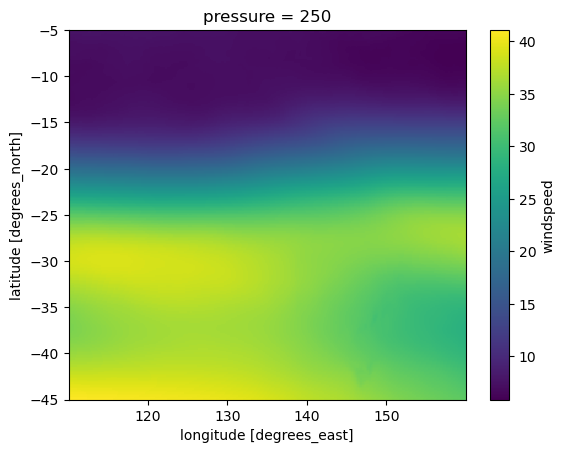

In [15]:
%%time
windspeed_barpa = ds_barpa['windspeed'].sel(pressure=250).mean("time").compute()
windspeed_barpa.plot()

CPU times: user 34.4 s, sys: 1.44 s, total: 35.8 s
Wall time: 19.7 s


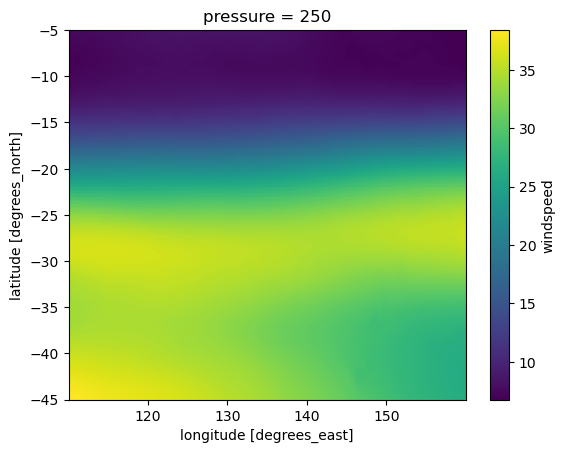

In [16]:
%%time
windspeed_era = ds_era5['windspeed'].sel(pressure=250, time=slice("1980", "1981")).mean("time").compute()
windspeed_era.plot()

CPU times: user 39.6 ms, sys: 168 μs, total: 39.8 ms
Wall time: 37.2 ms


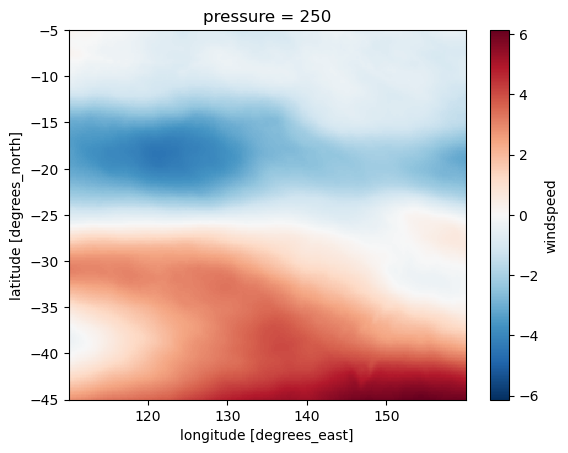

In [17]:
%%time
(windspeed_barpa - windspeed_era).plot()


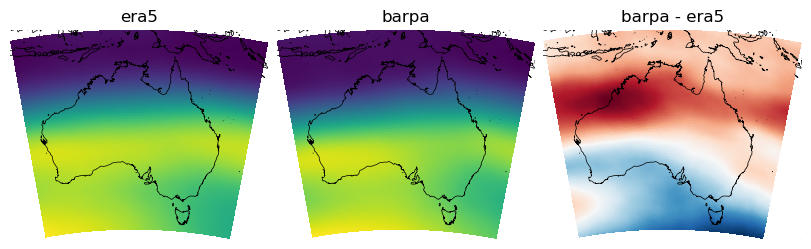

In [18]:
nrows = 1
ncols = 3
figsize = (8,6)
projection = ccrs.LambertConformal(
                central_latitude=-24.75,
                central_longitude=134.0,
                cutoff=30,
                standard_parallels=(-10, -40),
            )

fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            sharey=True, sharex=True, 
                            figsize=figsize,
                            layout="constrained",
                            subplot_kw={"projection":projection , "frame_on":False},)


axs[0].pcolormesh(windspeed_era.lon, windspeed_era.lat, windspeed_era, cmap=cm.viridis, transform=ccrs.PlateCarree(),)
axs[1].pcolormesh(windspeed_era.lon, windspeed_era.lat, windspeed_barpa, cmap=cm.viridis, transform=ccrs.PlateCarree(),)
axs[2].pcolormesh(windspeed_era.lon, windspeed_era.lat, (windspeed_barpa - windspeed_era), cmap=cm.RdBu, transform=ccrs.PlateCarree(),)

for i in range(3):
    axs[i].coastlines(resolution = "10m", zorder=5, linewidth=0.5,)
    axs[i].set_title(["era5", "barpa", "barpa - era5"][i])


CPU times: user 19.9 s, sys: 95.1 ms, total: 20 s
Wall time: 20.1 s


(<Figure size 670x450 with 5 Axes>,
 array([<GeoAxes: >, <GeoAxes: >], dtype=object))

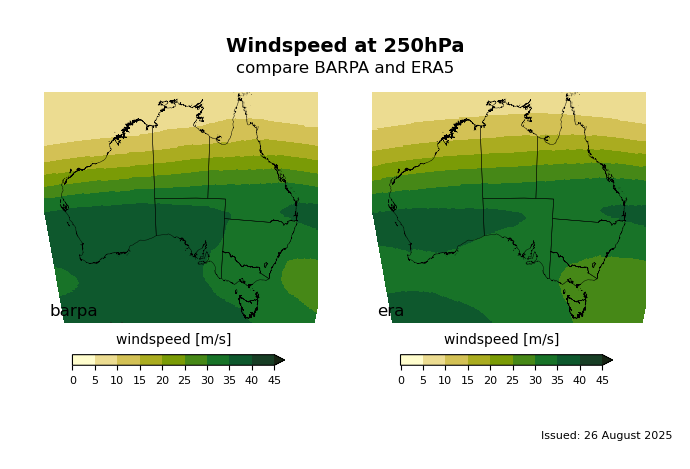

In [19]:
%%time
ds1 = windspeed_barpa
cmap1 = cmap_dict['ipcc_wind_seq']
ticks1 = np.arange(0, 50, 5)
tick_interval1 = 1
tick_rotation1=0
cbar_label1 = "windspeed [m/s]"
cbar_extend1="max"
agcd_mask1=False
subplot_titles1="barpa"
vcentre1=None

ds2 = windspeed_era
cmap2 =cmap_dict["ipcc_wind_seq"]
ticks2 = np.arange(0, 50, 5)
tick_interval2 = 1
tick_rotation2=0
cbar_label2 = "windspeed [m/s]"
cbar_extend2="max"
agcd_mask2=False
subplot_titles2="era"
vcentre2=None

plot_acs_hazard_multi(ds_list=[ds1, ds2],
                      ncols=2,
                      nrows=1,
                      figsize=(6.7,4.5),
                      regions=regions_dict['aus_states_territories'],
                      title= "Windspeed at 250hPa",
                      date_range="compare BARPA and ERA5",
                      cmap= [ cmap1, cmap2],
                      ticks=[ticks1, ticks2],
                      tick_interval=[tick_interval1 , tick_interval2],
                      tick_rotation=[tick_rotation1, tick_rotation2],
                      cbar_label=[cbar_label1, cbar_label2],
                      cbar_extend = [cbar_extend1, cbar_extend2],
                      agcd_mask=[agcd_mask1, agcd_mask2],
                      subplot_titles=[subplot_titles1, subplot_titles2],
                      vcentre=[vcentre1, vcentre2],
                     share_cbar=False,
                      mask_not_australia=False,
                     watermark="",
                     show_copyright=False,)                      

CPU times: user 1.78 s, sys: 10.4 ms, total: 1.79 s
Wall time: 1.81 s


(<Figure size 670x400 with 7 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >], dtype=object))

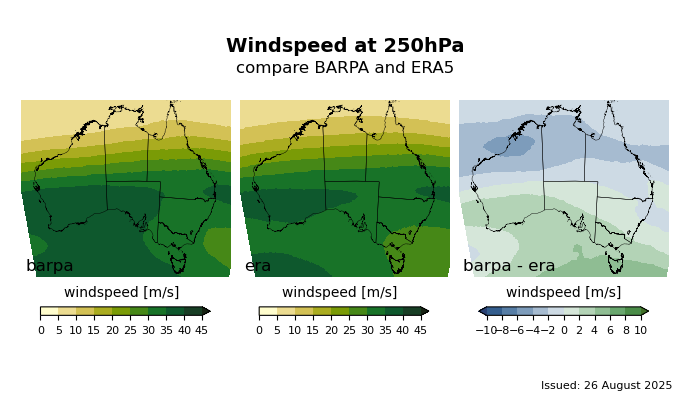

In [20]:
%%time
ds1 = windspeed_barpa
cmap1 = cmap_dict['ipcc_wind_seq']
ticks1 = np.arange(0, 50, 5)
tick_interval1 = 1
tick_rotation1=0
cbar_label1 = "windspeed [m/s]"
cbar_extend1="max"
agcd_mask1=False
subplot_titles1="barpa"
vcentre1=None

ds2 = windspeed_era
cmap2 =cmap_dict["ipcc_wind_seq"]
ticks2 = np.arange(0, 50, 5)
tick_interval2 = 1
tick_rotation2=0
cbar_label2 = "windspeed [m/s]"
cbar_extend2="max"
agcd_mask2=False
subplot_titles2="era"
vcentre2=None

ds3 = windspeed_barpa - windspeed_era
cmap3 =cmap_dict["ipcc_wind_div"]
ticks3 = np.arange(-10, 11, 2)
tick_interval3 = 1
tick_rotation3=0
cbar_label3 = "windspeed [m/s]"
cbar_extend3="both"
agcd_mask3=False
subplot_titles3="barpa - era"
vcentre3=0

plot_acs_hazard_multi(ds_list=[ds1, ds2, ds3],
                      ncols=3,
                      nrows=1,
                      figsize=(6.7,4),
                      regions=regions_dict['aus_states_territories'],
                      title= "Windspeed at 250hPa",
                      date_range="compare BARPA and ERA5",
                      cmap= [ cmap1, cmap2, cmap3],
                      ticks=[ticks1, ticks2, ticks3],
                      tick_interval=[tick_interval1 , tick_interval2, tick_interval3],
                      tick_rotation=[tick_rotation1, tick_rotation2, tick_rotation3],
                      cbar_label=[cbar_label1, cbar_label2, cbar_label3],
                      cbar_extend = [cbar_extend1, cbar_extend2, cbar_extend3],
                      agcd_mask=[agcd_mask1, agcd_mask2, agcd_mask3],
                      subplot_titles=[subplot_titles1, subplot_titles2, subplot_titles3],
                      vcentre=[vcentre1, vcentre2, vcentre3],
                     share_cbar=False,
                      mask_not_australia=False,
                     watermark="",
                     show_copyright=False,)                      

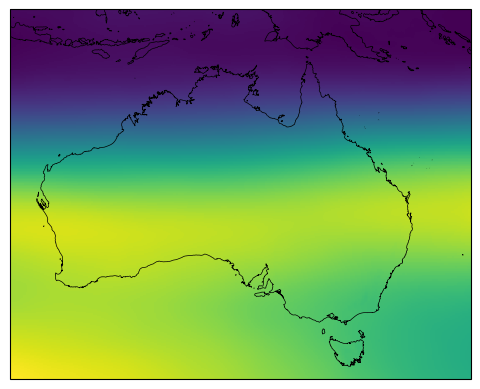

In [21]:
fig, ax = plt.subplots(1, subplot_kw={"projection":ccrs.PlateCarree(180)})
ax.pcolormesh(windspeed_era.lon, windspeed_era.lat, windspeed_era, cmap=cm.viridis,  transform=ccrs.PlateCarree())
ax.coastlines(resolution = "10m", zorder=5, linewidth=0.5,)

CPU times: user 57.3 s, sys: 3.55 s, total: 1min
Wall time: 1min 47s


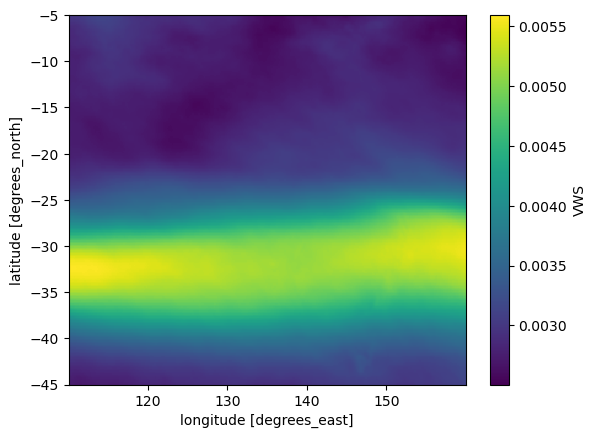

In [23]:
%%time
barpa_vws = ds_barpa['VWS'].mean("time").compute()
barpa_vws.plot()

In [ ]:

# combine all these into a function that takes the dataset and calculates all the indices
# ** may need a conversion to metres from lat/lon steps eg 0.15*110000*cos(latitude)

du_dx = ds["u"].sel(pressure=250).differentiate("lon")/ds["dx"]
dv_dy = ds["v"].sel(pressure=250).differentiate("lat")/ds["dy"]

dv_dx = ds["v"].sel(pressure=250).differentiate("lon")/ds["dx"]
du_dy = ds["u"].sel(pressure=250).differentiate("lat")/ds["dy"]

du_dz = (ds["u"].sel(pressure=200) - ds["u"].sel(pressure=300))/ds["dz"]
dv_dz = (ds["v"].sel(pressure=200) - ds["v"].sel(pressure=300))/ds["dz"]

In [ ]:
# # Example data to test index calculations

# VAR = "ua250"
# print(VAR)
# ds = xr.open_dataset(f"/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp126/r4i1p1f1/BARPA-R/v1-r1/6hr/{VAR}/v20231001/{VAR}_AUS-15_ACCESS-CM2_ssp126_r4i1p1f1_BOM_BARPA-R_v1-r1_6hr_203401-203412.nc", 
#                      use_cftime=True).rename({VAR:VAR[0]}).expand_dims({"pressure":[int(VAR[2:])]})

# for VAR in ["va250",]:
#     print(VAR)
#     ds = ds.merge(xr.open_dataset(f"/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp126/r4i1p1f1/BARPA-R/v1-r1/6hr/{VAR}/v20231001/{VAR}_AUS-15_ACCESS-CM2_ssp126_r4i1p1f1_BOM_BARPA-R_v1-r1_6hr_203401-203412.nc", 
#                       use_cftime=True).rename({VAR:VAR[0]}).expand_dims({"pressure":[int(VAR[2:])]}))
# ds

In [ ]:
# calculate horizontal windspeed
windspeed = (ds["u"]**2 +ds["v"]**2)**0.5
ds = ds.assign({"windspeed":windspeed})


In [ ]:
ds["windspeed"].sel(pressure=250).mean("time").plot()

In [ ]:
# convert degrees to metres
# 111km per deg 
# 40075 km * cos( latitude ) / 360
# 40000 km * cos( latitude ) / 360
step_size = 0.1545
step_size*111000

dy = (step_size *111000 * ds["lon"]**0 ).round()
dx = (step_size *111000 * np.cos( np.deg2rad(ds.lat))).round()
dz = ds["z"].sel(pressure=200) - ds["z"].sel(pressure=300)
ds = ds.assign({"dx":dx,
                "dy":dy,
                "dz":dz,})


# combine all these into a function that takes the dataset and calculates all the indices
# ** may need a conversion to metres from lat/lon steps eg 0.15*110000*cos(latitude)

du_dx = ds["u"].sel(pressure=250).differentiate("lon")/ds["dx"]
dv_dy = ds["v"].sel(pressure=250).differentiate("lat")/ds["dy"]

dv_dx = ds["v"].sel(pressure=250).differentiate("lon")/ds["dx"]
du_dy = ds["u"].sel(pressure=250).differentiate("lat")/ds["dy"]

du_dz = (ds["u"].sel(pressure=200) - ds["u"].sel(pressure=300))/ds["dz"]
dv_dz = (ds["v"].sel(pressure=200) - ds["v"].sel(pressure=300))/ds["dz"]

In [ ]:
# combine all these into a function that takes the dataset and calculates all the indices
# ** may need a conversion to metres from lat/lon steps eg 0.15*110000*cos(latitude)

du_dx = ds["u"].sel(pressure=250).differentiate("lon")/ds["dx"]
dv_dy = ds["v"].sel(pressure=250).differentiate("lat")/ds["dy"]

dv_dx = ds["v"].sel(pressure=250).differentiate("lon")/ds["dx"]
du_dy = ds["u"].sel(pressure=250).differentiate("lat")/ds["dy"]

du_dz = (ds["u"].sel(pressure=200) - ds["u"].sel(pressure=300))/ds["dz"]
dv_dz = (ds["v"].sel(pressure=200) - ds["v"].sel(pressure=300))/ds["dz"]


In [ ]:
# T1
# T2
# T3
# VWS
# DEF
# DIV
# DVT
# Need: u, v, grid and time
# N^2 <0 Brunt-Vӓisӓlӓ frequency
# Ri,  0 < Ri < 1
# PV <0
# Need θ, ζ, ρ, and f represent the potential temperature (from temperature and pressure), the relative vorticity, the air density (from ideal gas law and temperature), and the Coriolis parameter (from lat)


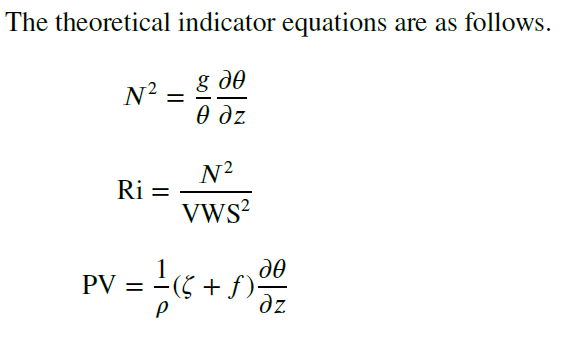

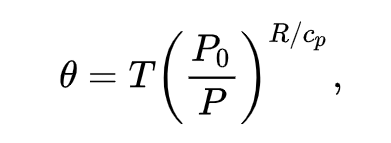


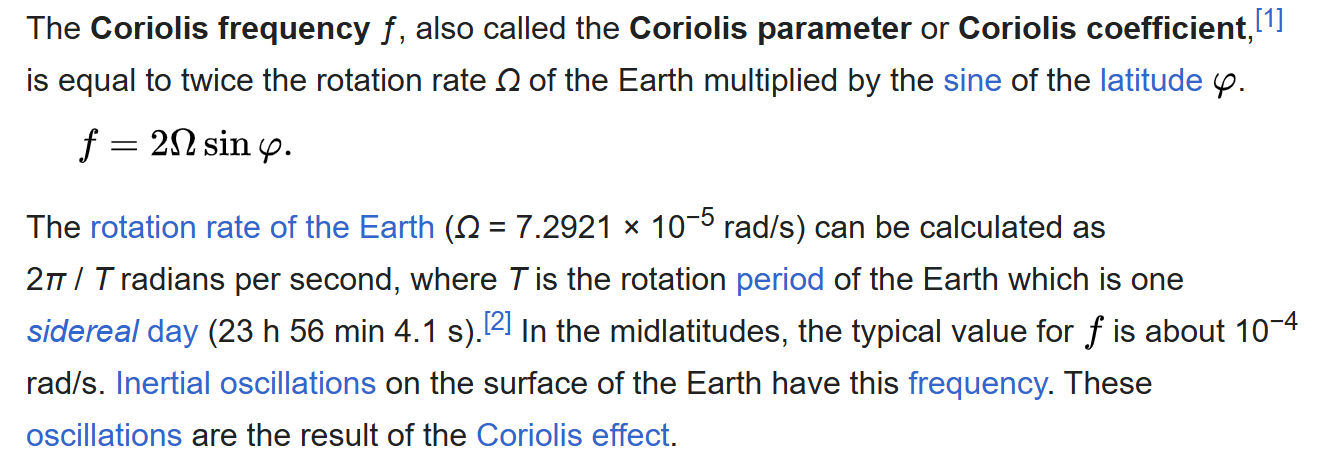

In [ ]:
# N^2 Brunt-Vӓisӓlӓ frequency

# Potential temperature from ideal gas law
theta = potential_temperature(T = ds["t"], P = ds["t"].pressure)
ds = ds.assign({"theta":theta})


# vertical temperature gradient
dtheta_dz = dtheta_dz(ds)

# gravitation force
g=9.8


N2 = g/theta * dtheta_dz
ds = ds.assign({"N2":N2})


In [ ]:
# coriolis frequency
# omega defined from Earth's rotation
omega = 7.2921*10**-5
f = 2*omega*np.sin(np.deg2rad(ds["lat"]))
ds = ds.assign({"f":f})

In [ ]:
# PV Potential Vorticity
zeta = dv_dx - du_dy

#PV
rho = air_density(ds["t"], P=ds.pressure)

pv = 1/rho * (zeta + f)* dtheta_dz
ds = ds.assign({"PV":pv})

In [ ]:
# calculate vertical wind shear
# VWS = ((du/dz)**2 + (dv/dz)**2)**0.5
VWS = ((du_dz)**2 + (dv_dz)**2)**0.5
ds = ds.assign({"VWS":VWS})

# calculate deformation
# DEF = ((du/dx -dv/dy)**2 + (dv/dx + du/dy)**2)**0.5
DEF = ((du_dx -dv_dy)**2 + (dv_dx + du_dy)**2)**0.5
ds = ds.assign({"DEF":DEF})

# calculate divergence
# DIV = du/dx+dv/dy
DIV = du_dx + dv_dy
# update the xr dataset
ds = ds.assign({"DIV":DIV})

# Calculate divergence tendency
C=0.01
# t=0
# DVT=C*((DIV.isel(time=t)-DIV.isel(time=t+1))**2)**0.5
DVT = C*((DIV.differentiate("time", datetime_unit="6h")**2)**0.5).isel(time=0)
ds = ds.assign({"DVT":DVT})

In [ ]:
# Richardson number
# The Ri less than some small number indicates Kelvin-Helmholtz instability when VWS is large and/or N2 is small.
Ri = N2/(VWS**2)
ds = ds.assign({"Ri":Ri})

In [ ]:
# from Lee et al 2022
TI1 = VWS * DEF
TI2 = VWS * (DEF - DIV)
TI3 = TI1 + DVT

ds = ds.assign({"TI1":TI1})
ds = ds.assign({"TI2":TI2})
ds = ds.assign({"TI3":TI3})

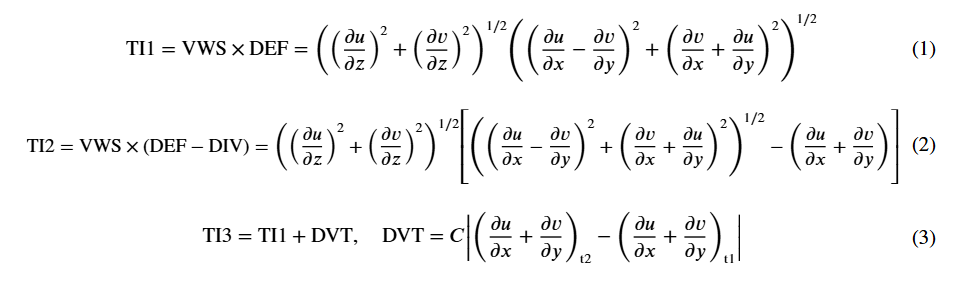


In [ ]:
ds


In [ ]:
# set alias
turbulence_index_1 = TI1
turbulence_index_2 = TI2
turbulence_index_3 = TI3
vertical_wind_shear = VWS
deformation = DEF
divergence = DIV
divergence_tendency = DVT

In [ ]:
ax = plt.subplot(projection=ccrs.Robinson(130))
DIV.isel(time=0).plot(transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
ax = plt.subplot(projection=ccrs.Robinson(130))
DEF.isel(time=0).plot(transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:

ax = plt.subplot(projection=ccrs.Robinson(130))
DVT.plot(transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
# This probably is a jet stream signature.

ax = plt.subplot(projection=ccrs.Robinson(130))
TI1.mean("time").plot(transform=ccrs.PlateCarree())
ax.coastlines()



In [ ]:

ax = plt.subplot(projection=ccrs.Robinson(130))
VWS.mean("time").plot(transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
# This probably is a jet stream signature.

fig, ax = plot_acs_hazard_multi(nrows=1,
                                ncols=1,
                                ds_list=[TI1.mean("time")], 
                            xlim=(100, 190),
                            ylim=(-55, 10),
                            cmap=cm.viridis,
                            ticks=np.arange(0,0.000005, 0.0000002),
                            mask_not_australia=False,
                            mask_australia=False,
                            watermark="",
                            projection=ccrs.Robinson(central_longitude=130),
                            coastlines=True,
                          show_copyright=False,
                          issued_date="",
                          title="TI1",
                            )



In [ ]:
ax = plt.subplot(projection=ccrs.Robinson(130))
pv.isel(time=0).sel(pressure=250).plot(transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
ax = plt.subplot(projection=ccrs.Robinson(130))
pv.sel(pressure=250).mean("time").plot(transform=ccrs.PlateCarree())
ax.coastlines()